In [78]:
import numpy as np
import sys
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline 

In [79]:
import sklearn
import sklearn.feature_selection
import sklearn.utils

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from collections import OrderedDict
import xgboost as xgb

### Import data, which was cleaning via full_cleaning notebook

In [169]:
df = pd.read_csv('./data/all_data_CLEAN.csv', index_col=0)

print(df.shape)
#df.head()

data = df.copy()

data['MSSubClass'] = data['MSSubClass'].astype(str)
# data['OverallQual'] = data['OverallQual'].astype(str)
# data['OverallCond'] = data['OverallCond'].astype(str)

(2552, 81)


In [170]:
ord_colnames = ['LotShape', 'LandSlope', 'OverallQual', 'OverallCond',
                'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
                'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
                'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

In [171]:
ord_dict = {}
ord_dict['LotShape'] = ['IR3', 'IR2', 'IR1', 'Reg']
ord_dict['LandSlope'] = ['Sev', 'Mod', 'Gtl']
ord_dict['OverallQual'] = [np.nan, 1,2,3,4,5,6,7,8,9,10]
ord_dict['OverallCond'] = [np.nan, 1,2,3,4,5,6,7,8,9,10]
ord_dict['ExterQual'] = [np.nan,'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['ExterCond'] = [np.nan, 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['BsmtQual'] = ['NoneListed', 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['BsmtCond'] = ['NoneListed', 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['BsmtExposure'] = ['NoneListed', 'No', 'Mn', 'Av', 'Gd']
ord_dict['BsmtFinType1'] = ['NoneListed', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
ord_dict['BsmtFinType2'] = ['NoneListed', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
ord_dict['HeatingQC'] = [np.nan, 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['KitchenQual'] = [np.nan, 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['Functional'] = ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
ord_dict['FireplaceQu'] = ['NoneListed', 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['GarageFinish'] = ['NoneListed', 'Unf', 'RFn', 'Fin']
ord_dict['GarageQual'] = ['NoneListed', 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['GarageCond'] = ['NoneListed', 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['PoolQC'] = ['NoneListed', 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['Fence'] = ['NoneListed', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

In [172]:
for i in range(len(ord_colnames)):
    data[ord_colnames[i]] = data[ord_colnames[i]].apply(lambda x: ord_dict[ord_colnames[i]].index(x))


In [173]:
nums = ['PID', 'SalePrice','SalePricePerGLA','GrLivArea','LotFrontage', 'LotArea', 
          'YearBuilt', 'YearRemodAdd','MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
          'BsmtUnfSF', 'TotalBsmtSF','1stFlrSF','2ndFlrSF', 'LowQualFinSF', 
          'BsmtFullBath', 'BsmtHalfBath', 'FullBath','HalfBath', 'BedroomAbvGr', 
          'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces','GarageYrBlt', 'GarageCars', 
          'GarageArea', 'WoodDeckSF', 'OpenPorchSF','EnclosedPorch', '3SsnPorch', 
          'ScreenPorch', 'PoolArea', 'MiscVal' , 'MoSold', 'YrSold']


In [174]:
top_twenty = list(data.nlargest((round(len(data)*.2)),'GrLivArea').PID)
bottom_eighty = list(data.nsmallest((round(len(data)*.8)),'GrLivArea').PID)

btm_80_df = data[data['PID'].isin(bottom_eighty)].copy()
top_20_df = data[data['PID'].isin(top_twenty)].copy()

print(btm_80_df.shape)
print(top_20_df.shape)
# btm_80_df['NBHD_mean'] = btm_80_df.groupby('Neighborhood')['SalePricePerGLA'].transform('mean')
# btm_80_df['NBHD_std'] = btm_80_df.groupby('Neighborhood')['SalePricePerGLA'].transform('std')

(2042, 81)
(510, 81)


In [175]:
cats_ords = list(set(btm_80_df.columns) - set(btm_80_df[nums].columns))

cats = list(set(btm_80_df[cats_ords].columns) - set(btm_80_df[ord_colnames].columns))
print("Nums len: ", len(nums),
      "\nOrds len: ", len(ord_colnames),
      "\nCats len: ", len(cats),
      "\nOG shape: ", len(btm_80_df.columns))
enc_cats_df = pd.get_dummies(btm_80_df[cats],drop_first=True)

nums_df = btm_80_df[nums]

ords_df = btm_80_df[ord_colnames]

Nums len:  36 
Ords len:  20 
Cats len:  25 
OG shape:  81


In [176]:
print("nums: ", nums_df.shape)
print("ords: ", ords_df.shape)
nums_ords = nums_df.join(ords_df)
print("nums_ords: ", nums_ords.shape)
#nums_ords.head()
print("enc_cats: ", enc_cats_df.shape)
full_df = nums_ords.join(enc_cats_df)
print("full_df: ", full_df.shape)

nums:  (2042, 36)
ords:  (2042, 20)
nums_ords:  (2042, 56)
enc_cats:  (2042, 157)
full_df:  (2042, 213)


### Putting all the data together so it can be used to train a model
And saving any columns that may be useful later

In [177]:
y_SP = full_df['SalePrice']
y_SPPGLA = full_df['SalePricePerGLA']
X_GLA = full_df['GrLivArea']
X_PID = full_df['PID']

print("With SP, GLA, and SPPGLA and PID: ", full_df.shape)

# full_data_df will make our lives much easier for getting predicted values
full_data_df = full_df.copy()
full_df.drop(['SalePrice'], axis=1, inplace=True)
full_df.drop(['SalePricePerGLA'], axis=1, inplace=True)
full_df.drop(['GrLivArea'], axis=1, inplace=True)
full_df.drop(['PID'], axis=1, inplace=True)

print("Without SP, GLA, SPPGLA, or PID: ", full_df.shape)

# Test data set sizes
print("SP shape: ",y_SP.shape)
print("SP shape: ",y_SPPGLA.shape)

With SP, GLA, and SPPGLA and PID:  (2042, 213)
Without SP, GLA, SPPGLA, or PID:  (2042, 209)
SP shape:  (2042,)
SP shape:  (2042,)


### Split the data into training and test sets, instantiate an XGBRegressor with parameters found in the parameter_tuning notebook

In [28]:
X_train, X_test, y_train, y_test = train_test_split(full_df, y_SPPGLA, test_size=0.25, random_state=42)

params = {'objective':'reg:squarederror',
          'colsample_bytree': 1,
          'gamma': 0.5,
          'learning_rate': 0.05,
          'max_depth': 3,
          'min_child_weight': 10,
          'n_estimators': 1000,
          'reg_alpha': 1,
          'reg_lambda': 3,
          'subsample': 0.4
         }

btm_80_xgbr = xgb.XGBRegressor(objective='reg:squarederror',
                               colsample_bytree = 1,
                               gamma = 0.5,
                               learning_rate = 0.05,
                               max_depth = 3,
                               min_child_weight = 10,
                               n_estimators = 1000,
                               reg_alpha = 1,
                               reg_lambda = 3,
                               subsample = 0.4)

### Perform 10-fold cross validation on the train split

In [29]:
kfold = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(btm_80_xgbr, X_train, y_train, cv=kfold)

C:\Users\pengu\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\pengu\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\pengu\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\pengu\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\pengu\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\pengu\Anaco

In [30]:
print("Mean cross-validation score is %.5f with std of %.5f" % (scores.mean(), scores.std()))

Mean cross-validation score is 0.81687 with std of 0.03416


In [31]:
btm_80_xgbr.fit(X_train, y_train)
#best_xgbr.score(X_train, y_train)
#best_xgbr.fit(X_test,y_test)
btm_80_xgbr.score(X_test, y_test)

C:\Users\pengu\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.8380700942329928

### Get the feature importance as a dictionary and convert it into a dataframe for future use

In [32]:
#%%capture
rel_features_dict = OrderedDict(sorted(btm_80_xgbr.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=False))
rel_features = pd.DataFrame.from_dict(rel_features_dict,orient='index', columns = ['Weight'])

### Plot feature importance

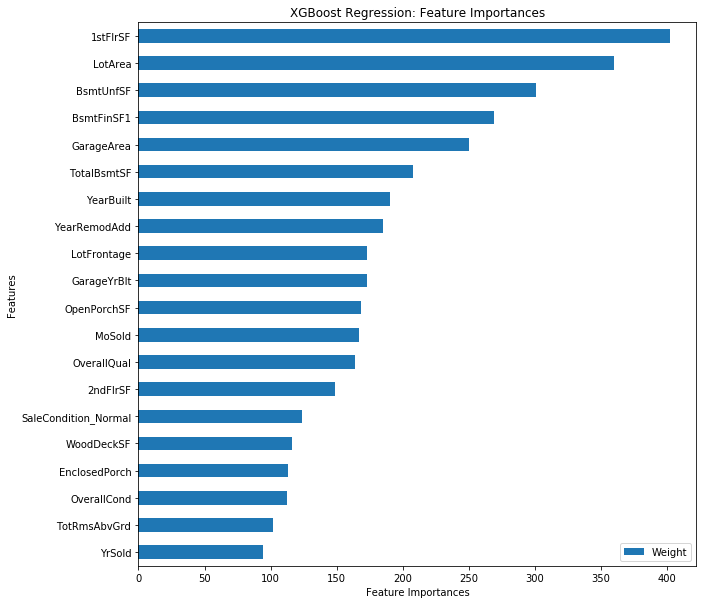

In [59]:
fig = rel_features.tail(20).plot.barh()
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel('Feature Importances')
plt.ylabel('Features')
plt.title('XGBoost Regression: Feature Importances')
plt.show()

In [63]:
rel_features.sort_values(by=['Weight'], ascending=False).head(20)

,Weight
1stFlrSF,402
LotArea,360
BsmtUnfSF,301
BsmtFinSF1,269
GarageArea,250
TotalBsmtSF,208
YearBuilt,190
YearRemodAdd,185
LotFrontage,173
GarageYrBlt,173


### These features were determined to be too difficult (or impossible) to change, and therefore will not be considered for improvement

In [ ]:
unchangeable_feats = ([feat for feat in list(rel_features.index) if 'Neighborhood' in feat] +
 [feat for feat in list(rel_features.index) if 'Condition1' in feat] +
 [feat for feat in list(rel_features.index) if 'Condition2' in feat] +
 [feat for feat in list(rel_features.index) if 'Exterior1st' in feat] +
 [feat for feat in list(rel_features.index) if 'MSSubClass' in feat] +
 [feat for feat in list(rel_features.index) if 'SaleCondition' in feat] +
 [feat for feat in list(rel_features.index) if 'GarageType' in feat] +
 [feat for feat in list(rel_features.index) if 'LandContour' in feat] +
 [feat for feat in list(rel_features.index) if 'MSZoning' in feat] +
 [feat for feat in list(rel_features.index) if 'HouseStyle' in feat] +
 [feat for feat in list(rel_features.index) if 'Foundation' in feat] +
 [feat for feat in list(rel_features.index) if 'LotConfig' in feat] +
 ['LotShape'] + ['ExterQual'] + ['const'] + ['YearBuilt'] + ['2ndFlrSF'] +
 ['GarageArea '] + ['BedroomAbvGr'] + ['LotArea'] + ['LotFrontage'] + ['GarageYrBlt'] +
 ['MoSold'] + ['YrSold'] + ['LandSlope'] + ['1stFlrSF'] + ['BsmtUnfSF'] + ['TotalBsmtSF'] +
 ['LotFrontage'] + ['GarageArea'] + ['TotRmsAbvGrd'])

changeable_feats = list(set(rel_features.index) - set(unchangeable_feats))

chng_rel_feats = rel_features[rel_features.index.isin(changeable_feats)]

### Plot the most important changeable (improvable) features

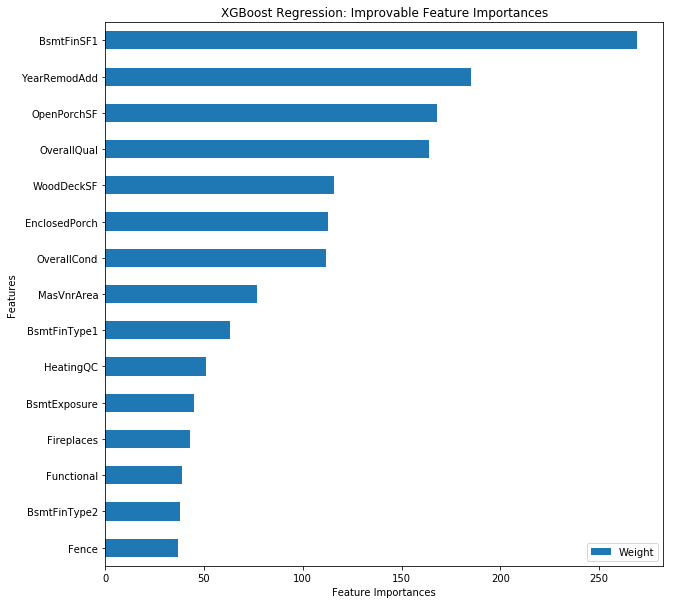

In [64]:
chng_rel_feats.tail(15).plot.barh()
plt.xlabel('Feature Importances')
plt.ylabel('Features')
plt.title('XGBoost Regression: Improvable Feature Importances')
plt.show()

In [67]:
chng_rel_feats.sort_values(by=['Weight'], ascending=False).head(15)

,Weight
BsmtFinSF1,269
YearRemodAdd,185
OpenPorchSF,168
OverallQual,164
WoodDeckSF,116
EnclosedPorch,113
OverallCond,112
MasVnrArea,77
BsmtFinType1,63
HeatingQC,51


In [178]:
btm_80_df['NBHD_mean'] = btm_80_df.groupby('Neighborhood')['SalePricePerGLA'].transform('mean')
btm_80_df['NBHD_std'] = btm_80_df.groupby('Neighborhood')['SalePricePerGLA'].transform('std')

### We used the neighborhood mean and std to determine whether a home was undervalued (according to its SalePricePerGLA)

In [179]:
btm_80_df.dropna(inplace=True)

under_val_df = btm_80_df[ btm_80_df['SalePricePerGLA'] < (btm_80_df['NBHD_mean']-btm_80_df['NBHD_std'])].copy()


under_val_df['Naive_SalePrice'] = under_val_df['GrLivArea']*under_val_df['SalePricePerGLA']
print(under_val_df.shape)


(308, 84)


In [180]:
feats_to_improve = chng_rel_feats.sort_values(by=['Weight'], ascending=False).head(15).index
feats_to_improve

Index(['BsmtFinSF1', 'YearRemodAdd', 'OpenPorchSF', 'OverallQual',
       'WoodDeckSF', 'EnclosedPorch', 'OverallCond', 'MasVnrArea',
       'BsmtFinType1', 'HeatingQC', 'BsmtExposure', 'Fireplaces', 'Functional',
       'BsmtFinType2', 'Fence'],
      dtype='object')

#### This was used to find the improvable ordinal features

In [181]:
ord_colnames = ['OverallQual', 'OverallCond',
                'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
                'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
                'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

improvable_non_ords = list(set(feats_to_improve) - set(ord_colnames))
improvable_ords = list(set(feats_to_improve) - set(improvable_non_ords))

print("# of Feats to improve: ", len(feats_to_improve))
print("# of Ords: ", len(improvable_ords))
print("# of Not Ords: ", len(improvable_non_ords))

print(improvable_ords)

# of Feats to improve:  15
# of Ords:  8
# of Not Ords:  7
['BsmtExposure', 'Fence', 'HeatingQC', 'BsmtFinType2', 'Functional', 'OverallQual', 'BsmtFinType1', 'OverallCond']


In [184]:
underval_preds = under_val_df.copy()

uv_SP = underval_preds['SalePrice']
uv_SPPGLA = underval_preds['SalePricePerGLA']
uv_GLA = underval_preds['GrLivArea']
uv_PID = underval_preds['PID']

# underval_preds.drop(['SalePrice', 'SalePricePerGLA', 'GrLivArea', 'PID',], axis=1, inplace=True)
# underval_preds.drop(['NBHD_mean', 'NBHD_std', 'Naive_SalePrice'], axis=1, inplace=True)

#underval_preds.columns

#### Getting just the common features across all the models

In [192]:
rf_improvable_feat = ['OverallQual', 'BsmtFinType1', 'OverallCond', 'BsmtFinSF1', 'YearRemodAdd',
'BsmtUnfSF', 'Functional', 'TotRmsAbvGrd', 'BsmtQual', 'KitchenAbvGr',
'WoodDeckSF', 'OpenPorchSF', 'BsmtExposure', 'EnclosedPorch', 'KitchenQual']
xgboost_improvable_feat = ['BsmtFinSF1', 'YearRemodAdd', 'OpenPorchSF', 'OverallQual',
       'WoodDeckSF', 'EnclosedPorch', 'OverallCond', 'MasVnrArea',
       'BsmtFinType1', 'HeatingQC', 'BsmtExposure', 'Fireplaces', 'Functional',
       'BsmtFinType2', 'Fence']
svr_improvable_feat = ['OverallQual', 'OverallCond', 'BsmtFinSF1', 'BsmtExposure', 'MasVnrType_None',
 'MasVnrType_BrkFace', 'KitchenQual', 'MiscFeature_NoneListed', 'BsmtQual', 'BsmtFullBath',
 'MiscFeature_Shed', 'MasVnrArea', 'Functional', 'FireplaceQu', 'KitchenAbvGr',
 'BsmtUnfSF', 'LowQualFinSF']
common_improvable_feat = [feat for feat in [feat for feat in rf_improvable_feat if feat in xgboost_improvable_feat] if feat in svr_improvable_feat]
common_improvable_feat

['OverallQual', 'OverallCond', 'BsmtFinSF1', 'Functional', 'BsmtExposure']

### Giving the undervalued homes new values in the common features

In [185]:
uv_df = full_data_df[full_data_df['PID'].isin(uv_PID)].copy()

uv_df.loc[:,'BsmtExposure'] = 3 # Av
uv_df.loc[:,'Functional'] = 6 #'Min1'
uv_df.loc[:,'OverallQual'] = 9
uv_df.loc[:,'OverallCond'] = 9

#### To increase Basement Finished Square Footage, your unfinished basement square footage would decrease

In [186]:
uv_old_BsmtFinSF1 = uv_df['BsmtFinSF1']
uv_df['BsmtFinSF1'] = uv_df['BsmtFinSF1'] + (uv_df['BsmtUnfSF']/2)
uv_old_BsmtUnfSF = uv_df['BsmtUnfSF']
uv_df['BsmtUnfSF'] = uv_df['BsmtUnfSF']/2

In [187]:
uv_df.drop(['SalePrice'], axis=1, inplace=True)
uv_df.drop(['SalePricePerGLA'], axis=1, inplace=True)
uv_df.drop(['GrLivArea'], axis=1, inplace=True)
uv_df.drop(['PID'], axis=1, inplace=True)

### Predicting the new SPperGLA for each undervalued home

In [188]:
uv_pred = btm_80_xgbr.predict(uv_df)
uv_df['pred_SPPGLA'] = uv_pred

In [189]:
uv_df['PID'] = uv_PID
uv_df['SalePrice'] = uv_SP
uv_df['SalePricePerGLA'] = uv_SPPGLA
uv_df['GrLivArea'] = uv_GLA

#### Calculating the new SalePrice based on the predicted SPperGLA

In [190]:
uv_df['pred_SP'] = uv_df['pred_SPPGLA'] * uv_df['GrLivArea']
uv_df['gained_SP'] = uv_df['pred_SP'] - uv_df['SalePrice']

In [205]:
top_uv = uv_df[['PID','GrLivArea','SalePricePerGLA','SalePrice','pred_SPPGLA','pred_SP','gained_SP']].sort_values(by=['gained_SP'], ascending=False).head(30)

In [206]:
uv_df.shape

(308, 216)

#### This lists the top 30 homes that would see the greatest increase in sale price if improved accordingly

In [207]:
list(top_uv['PID'])

[908275110,
 535126100,
 923125030,
 534252060,
 528228295,
 534427010,
 533352150,
 905200290,
 535354260,
 902305090,
 535475020,
 532479120,
 905226110,
 905103060,
 535452120,
 902207130,
 905450020,
 923205025,
 535325320,
 916402115,
 911102170,
 923202060,
 534451150,
 535327230,
 902301060,
 535150070,
 905478030,
 916402015,
 526302120,
 909256060]